### well structured - an ode to databases


# data preparation

### import libraries

In [298]:
import yfinance as yf
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

## build stock preparation class

In [409]:
class stock_prep:
    def __init__(self, ticker_symbol):
       
        # load data
        self.ticker_symbol = ticker_symbol
        self.company_name = yf.Ticker(self.ticker_symbol).info['longName'].replace(r'/', ' ')
        self.currency = yf.Ticker(self.ticker_symbol).info['currency']


        # return dfs
        self.company_stock_prices = []
        self.trim_company_stock_price = []
        self.replace_company_stock_prices = []
        self.missing_company_stock_prices = []
        self.avg_norm_loss_company_stock_prices = []
        self.formatted_date_to_index = []
        self.standardization_company_stock_prices = []
        self.normalization_company_stock_prices = []
        self.binning_company_stock_prices = []
        self.indicator_variables_stock_prices = []
        self.to_sql_stock_prices = []

    # ------------------------ DATABASE -----------------------------------------
        
    def to_sqlite_database(self, db_name):

        conn = sqlite3.connect(db_name)
        self.to_sql_stock_prices.to_sql(name=self.company_name, con=conn, if_exists='replace')
        conn.commit()
        conn.close() 

    def read_sqlite_database(self, ticker_symbol, db_name, columns):
        
       
        company_name = yf.Ticker(ticker_symbol).info['longName'].replace(r'/', ' ')
        print(company_name) 
        print(columns)
        conn = sqlite3.connect(db_name)
        sql = "SELECT " + columns + " FROM `" + company_name + "`"
        print(sql)
        result = pd.read_sql(sql,conn)
        return result
       
    # ------------------------ DATA ----------------------------------------- 
    
    def replace_values(self):
        self.company_stock_prices = self.read_sqlite_database(self.ticker_symbol, 'stocks_prep.db', 'date, `close_trim_' + self.ticker_symbol + '`')
        self.replace_company_stock_prices = self.company_stock_prices.replace("Null", np.nan)
        print(self.replace_company_stock_prices.head(2))
        
    def missing_values_count(self):

        # count missing values
        self.missing_company_stock_prices = self.replace_company_stock_prices.isnull()
        self.missing_company_stock_prices = self.missing_company_stock_prices['close_trim_' + self.ticker_symbol].value_counts()
        print(self.missing_company_stock_prices.head(2))
    
    def avg_norm_loss(self):

        # calculate mean and replace missing values
        aux_var_avg_norm_loss = self.replace_company_stock_prices['close_trim_' + self.ticker_symbol].astype("float").mean(axis=0)
        self.avg_norm_loss_company_stock_prices = self.replace_company_stock_prices['close_trim_' + self.ticker_symbol].replace(np.nan, aux_var_avg_norm_loss)

        # rename Series for df
        first_item = self.replace_company_stock_prices['date'] #.rename('date_date')
        second_item = self.avg_norm_loss_company_stock_prices #['Close'].rename('close_avg_norm_loss')

        # build df
        self.avg_norm_loss_company_stock_prices = pd.concat([first_item, second_item], axis=1) 
        print(self.avg_norm_loss_company_stock_prices.head(2))
        
    def standardization(self):
        
        aux_var_euro_dollar = self.read_sqlite_database('EURUSD=X', 'stocks_prep.db', 'date, `close_trim_EURUSD=X`')

        print(aux_var_euro_dollar['close_trim_EURUSD=X'].head(2))
        print(self.avg_norm_loss_company_stock_prices['close_trim_' + self.ticker_symbol].head(2))


        # standardize close_avg_norm_loss
        aux_var_form_ind = self.avg_norm_loss_company_stock_prices['close_trim_' + self.ticker_symbol]/aux_var_euro_dollar['close_trim_EURUSD=X']

        # rename Series for df
        first_item = self.avg_norm_loss_company_stock_prices
        second_item =  aux_var_form_ind.rename("close_stand_" + self.ticker_symbol)

        # build df        
        self.standardization_company_stock_prices = pd.concat([first_item, second_item], axis=1)
        
    def normalization(self):

        # replace (original value) by (original value)/(maximum value)
        aux_var_norm_close = self.standardization_company_stock_prices['close_stand_' + self.ticker_symbol]/self.standardization_company_stock_prices['close_stand_' + self.ticker_symbol].max()

        # rename Series for df
        first_item = self.standardization_company_stock_prices
        second_item = aux_var_norm_close.rename("close_normal_" + self.ticker_symbol)

        # build df
        self.normalization_company_stock_prices = pd.concat([first_item, second_item], axis=1)
        
    def binning(self):

        # build bins
        aux_var_bins = np.linspace(min(self.normalization_company_stock_prices["close_normal_"  + self.ticker_symbol]), max(self.normalization_company_stock_prices["close_normal_" + self.ticker_symbol]), 4)
        aux_var_group_names = ["Low", "Medium", "High"]
        aux_var_build_bins = pd.cut(self.normalization_company_stock_prices['close_normal_' + self.ticker_symbol], aux_var_bins, labels = aux_var_group_names, include_lowest= True)

        # rename Series for df
        first_item = self.normalization_company_stock_prices
        second_item = aux_var_build_bins.rename("close_binned_" + self.ticker_symbol)

        print()

        # build df
        self.binning_company_stock_prices = pd.concat([first_item, second_item], axis=1)

    def indicator_variables(self):

        # build indicators
        aux_var_indi = pd.get_dummies(self.binning_company_stock_prices["close_binned_" + self.ticker_symbol])
        aux_var_drop = self.binning_company_stock_prices.drop(['close_binned_' + self.ticker_symbol], axis = 1)

        # rename Series for df
        first_item = aux_var_drop
        second_item = aux_var_indi #.rename(columns={'Medium':'close_price_medium', 'High':'close_price_high'}, inplace=True)

        # # build df
        self.indicator_variables_stock_prices = pd.concat([first_item, second_item], axis=1)

    def trim_same_length(self, ticker_symbols):
        
        # load data
        first_aux_var_corr = self.read_sqlite_database(self.ticker_symbol, 'stocks_orig.db', 'Date, Close')
        print(first_aux_var_corr)

        # rename Series for df
        first_item = first_aux_var_corr.rename(columns={"Date" : "date", "Close": "close_trim_" + self.ticker_symbol})
        
        for ticker_symbol in ticker_symbols:

            # load data
            second_aux_var_corr = self.read_sqlite_database(ticker_symbol, 'stocks_orig.db', 'Date, Close') 

            # rename Series for df
            second_item = second_aux_var_corr.rename(columns={"Date" : "date", "Close": "close_trim_" + ticker_symbol})

            # build df
            first_item = pd.merge(first_item, second_item, how = "outer", on = ['date', 'date'])

        # load data
        second_item = self.read_sqlite_database('EURUSD=X', 'stocks_orig.db', 'Date, Close')

        # rename Series for df
        second_item = second_aux_var_corr.rename(columns={"Date" : "date", "Close": "close_trim_EURUSD=X"})

        self.trim_company_stock_price = pd.merge(first_item, second_item, how = "left", on = ['date', 'date'])

        self.trim_company_stock_price



    # ------------------------ VISUALISATION -----------------------------------------

    def plot_bins_hist(self):
        print('hello')

        print(self.binning_company_stock_prices["close_binned_" + self.ticker_symbol])

        plt.hist(self.binning_company_stock_prices["close_binned_" + self.ticker_symbol], bins = 3)
       
        plt.xlabel("amount")
        plt.ylabel("close_binned_" + self.ticker_symbol)
        plt.title("Close_Price_Categories")

    
    def format_date_to_index(self):

        # format date to int
        aux_var_replaced_date = self.avg_norm_loss_company_stock_prices['date_date'].str.replace('-', '', regex=True).astype(np.int64)
        self.avg_norm_loss_company_stock_prices['close_avg_norm_loss'] = self.avg_norm_loss_company_stock_prices['close_avg_norm_loss'].astype(np.float64)

        # rename Series for df
        first_item = self.avg_norm_loss_company_stock_prices
        second_item = aux_var_replaced_date.rename('date_int')

        # build df
        self.formatted_date_to_index = pd.concat([first_item, second_item], axis=1)
      
    

    

## trim length

In [381]:
stock_prep_obj = stock_prep('WOOE.AS')
ticker_symbols = ['WY', 'SCA-B.ST' , 'SUZ', 'SK3.IR', 'IP', 'STERV.HE','RYN', 'WFG', 'WRK', 'PCH']

# trim lenght 
stock_prep_obj.trim_same_length(ticker_symbols)
aux_val_company_stock_price = stock_prep_obj.trim_company_stock_price
aux_val_company_stock_price.head() 

iShares Global Timber & Forestry UCITS ETF USD Acc
Date, Close
SELECT Date, Close FROM `iShares Global Timber & Forestry UCITS ETF USD Acc`
                    Date      Close
0    2021-11-05 00:00:00  30.709400
1    2021-11-08 00:00:00  30.705601
2    2021-11-09 00:00:00  30.667200
3    2021-11-10 00:00:00  30.441799
4    2021-11-11 00:00:00  30.740801
..                   ...        ...
604  2024-03-22 00:00:00  28.428900
605  2024-03-25 00:00:00  28.478600
606  2024-03-26 00:00:00  28.685301
607  2024-03-27 00:00:00  28.638100
608  2024-03-28 00:00:00  28.737900

[609 rows x 2 columns]
Weyerhaeuser Company
Date, Close
SELECT Date, Close FROM `Weyerhaeuser Company`
Svenska Cellulosa Aktiebolaget SCA (publ)
Date, Close
SELECT Date, Close FROM `Svenska Cellulosa Aktiebolaget SCA (publ)`
Suzano S.A.
Date, Close
SELECT Date, Close FROM `Suzano S.A.`
Smurfit Kappa Group Plc
Date, Close
SELECT Date, Close FROM `Smurfit Kappa Group Plc`
International Paper Company
Date, Close
SELECT Date, C

,date,close_trim_WOOE.AS,close_trim_WY,close_trim_SCA-B.ST,close_trim_SUZ,close_trim_SK3.IR,close_trim_IP,close_trim_STERV.HE,close_trim_RYN,close_trim_WFG,close_trim_WRK,close_trim_PCH,close_trim_EURUSD=X
0,2021-11-01 00:00:00,NaN,36.980000,138.649994,8.70,45.939999,49.099998,14.50,37.990002,80.120003,47.790001,53.889999,53.889999
1,2021-11-02 00:00:00,NaN,36.150002,135.500000,8.64,45.490002,48.950001,14.31,37.669998,80.250000,47.139999,53.250000,53.250000
2,2021-11-03 00:00:00,NaN,38.270000,137.250000,8.94,45.470001,49.910000,14.51,39.400002,83.269997,48.419998,56.880001,56.880001
3,2021-11-04 00:00:00,NaN,38.139999,134.949997,8.78,45.520000,48.750000,14.36,39.299999,83.349998,47.970001,56.889999,56.889999
4,2021-11-05 00:00:00,30.7094,38.330002,133.550003,8.95,45.070000,48.869999,14.46,38.930000,83.639999,48.759998,56.990002,56.990002


In [382]:
stock_prep_obj.trim_company_stock_price['date'].describe()

count                     624
unique                    624
top       2021-11-01 00:00:00
freq                        1
Name: date, dtype: object

## store values in database

In [383]:
ticker_symbols = ['WOOE.AS', 'WY', 'SCA-B.ST' , 'SUZ', 'SK3.IR', 'IP', 'STERV.HE','RYN', 'WFG', 'WRK', 'PCH', 'EURUSD=X']
aux_val_company_stock_price

for ticker_symbol in ticker_symbols:
    stock_prep_obj = stock_prep(ticker_symbol)
    stock_prep_obj.indicator_variables_stock_prices = aux_val_company_stock_price[['date','close_trim_' + ticker_symbol]]
    stock_prep_obj.to_sqlite_database('stocks_prep.db')

## handling missing values

In [425]:
stock_prep_obj = stock_prep('EURUSD=X')

In [426]:
# replace missing values
stock_prep_obj.replace_values()
print(stock_prep_obj.replace_company_stock_prices.head(5))

EUR USD
date, `close_trim_EURUSD=X`
SELECT date, `close_trim_EURUSD=X` FROM `EUR USD`
                  date  close_trim_EURUSD=X
0  2021-11-01 00:00:00            53.889999
1  2021-11-02 00:00:00            53.250000
                  date  close_trim_EURUSD=X
0  2021-11-01 00:00:00            53.889999
1  2021-11-02 00:00:00            53.250000
2  2021-11-03 00:00:00            56.880001
3  2021-11-04 00:00:00            56.889999
4  2021-11-05 00:00:00            56.990002


In [427]:
# handling missing values
stock_prep_obj.avg_norm_loss()
print(stock_prep_obj.avg_norm_loss_company_stock_prices.head(5))

                  date  close_trim_EURUSD=X
0  2021-11-01 00:00:00            53.889999
1  2021-11-02 00:00:00            53.250000
                  date  close_trim_EURUSD=X
0  2021-11-01 00:00:00            53.889999
1  2021-11-02 00:00:00            53.250000
2  2021-11-03 00:00:00            56.880001
3  2021-11-04 00:00:00            56.889999
4  2021-11-05 00:00:00            56.990002


In [428]:


stock_prep_obj.to_sqlite_database('stocks_prep.db')

AttributeError: 'list' object has no attribute 'to_sql'

## identify and handling missing values

In [410]:
stock_prep_obj = stock_prep('WOOE.AS')

In [411]:
# replace missing values
stock_prep_obj.replace_values()
print(stock_prep_obj.replace_company_stock_prices.head(5))

iShares Global Timber & Forestry UCITS ETF USD Acc
date, `close_trim_WOOE.AS`
SELECT date, `close_trim_WOOE.AS` FROM `iShares Global Timber & Forestry UCITS ETF USD Acc`
                  date  close_trim_WOOE.AS
0  2021-11-01 00:00:00                 NaN
1  2021-11-02 00:00:00                 NaN
                  date  close_trim_WOOE.AS
0  2021-11-01 00:00:00                 NaN
1  2021-11-02 00:00:00                 NaN
2  2021-11-03 00:00:00                 NaN
3  2021-11-04 00:00:00                 NaN
4  2021-11-05 00:00:00             30.7094


In [412]:
# identify missing values
stock_prep_obj.missing_values_count()
#print(stock_prep_obj.missing_company_stock_prices)

close_trim_WOOE.AS
False    609
True      15
Name: count, dtype: int64


In [413]:
# handling missing values
stock_prep_obj.avg_norm_loss()
print(stock_prep_obj.avg_norm_loss_company_stock_prices.head(5))

                  date  close_trim_WOOE.AS
0  2021-11-01 00:00:00           26.670818
1  2021-11-02 00:00:00           26.670818
                  date  close_trim_WOOE.AS
0  2021-11-01 00:00:00           26.670818
1  2021-11-02 00:00:00           26.670818
2  2021-11-03 00:00:00           26.670818
3  2021-11-04 00:00:00           26.670818
4  2021-11-05 00:00:00           30.709400


## correct dataformat

In [307]:
#stock_prep_obj.format_date_to_index()
#print(stock_prep_obj.formatted_date_to_index.head(5))

## data standardization

In [414]:
stock_prep_obj.standardization()
print(stock_prep_obj.standardization_company_stock_prices.head(5))


EUR USD
date, `close_trim_EURUSD=X`
SELECT date, `close_trim_EURUSD=X` FROM `EUR USD`
0    53.889999
1    53.250000
Name: close_trim_EURUSD=X, dtype: float64
0    26.670818
1    26.670818
Name: close_trim_WOOE.AS, dtype: float64
                  date  close_trim_WOOE.AS  close_stand_WOOE.AS
0  2021-11-01 00:00:00           26.670818             0.494912
1  2021-11-02 00:00:00           26.670818             0.500860
2  2021-11-03 00:00:00           26.670818             0.468896
3  2021-11-04 00:00:00           26.670818             0.468814
4  2021-11-05 00:00:00           30.709400             0.538856


# normalization

In [415]:
stock_prep_obj.normalization()
print(stock_prep_obj.normalization_company_stock_prices.head(5))

                  date  close_trim_WOOE.AS  close_stand_WOOE.AS  \
0  2021-11-01 00:00:00           26.670818             0.494912   
1  2021-11-02 00:00:00           26.670818             0.500860   
2  2021-11-03 00:00:00           26.670818             0.468896   
3  2021-11-04 00:00:00           26.670818             0.468814   
4  2021-11-05 00:00:00           30.709400             0.538856   

   close_normal_WOOE.AS  
0              0.798821  
1              0.808422  
2              0.756830  
3              0.756697  
4              0.869750  


## binning

In [418]:
stock_prep_obj.binning()
print(stock_prep_obj.binning_company_stock_prices.head(5))
#stock_prep_obj.plot_bins_hist()


                  date  close_trim_WOOE.AS  close_stand_WOOE.AS  \
0  2021-11-01 00:00:00           26.670818             0.494912   
1  2021-11-02 00:00:00           26.670818             0.500860   
2  2021-11-03 00:00:00           26.670818             0.468896   
3  2021-11-04 00:00:00           26.670818             0.468814   
4  2021-11-05 00:00:00           30.709400             0.538856   

   close_normal_WOOE.AS close_binned_WOOE.AS  
0              0.798821                  Low  
1              0.808422                  Low  
2              0.756830                  Low  
3              0.756697                  Low  
4              0.869750               Medium  


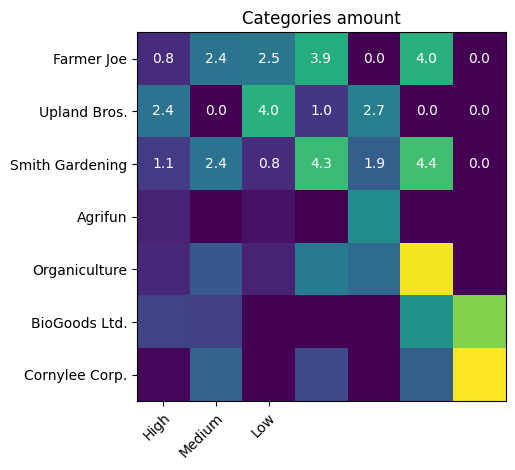

In [ ]:
categories = ["High", "Medium", "Low"]
company_names = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

amount = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])

categories = ["High", "Medium", "Low"]
company_names = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]


fig, ax = plt.subplots()
im = ax.imshow(amount)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(categories)), labels=categories)
ax.set_yticks(np.arange(len(company_names)), labels=company_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(categories)):
        for j in range(len(company_names)):
                text = ax.text(j, i, amount[i, j],
                        ha="center", va="center", color="w")

ax.set_title("Categories amount")
fig.tight_layout()
plt.show()    


## indicator Variables

In [417]:
stock_prep_obj.indicator_variables()
print(stock_prep_obj.indicator_variables_stock_prices.head(5))

                  date  close_trim_WOOE.AS  close_stand_WOOE.AS  \
0  2021-11-01 00:00:00           26.670818             0.494912   
1  2021-11-02 00:00:00           26.670818             0.500860   
2  2021-11-03 00:00:00           26.670818             0.468896   
3  2021-11-04 00:00:00           26.670818             0.468814   
4  2021-11-05 00:00:00           30.709400             0.538856   

   close_normal_WOOE.AS    Low  Medium   High  
0              0.798821   True   False  False  
1              0.808422   True   False  False  
2              0.756830   True   False  False  
3              0.756697   True   False  False  
4              0.869750  False    True  False  


## store in  stock_prep db

In [419]:
stock_prep_obj.to_sqlite_database('stocks_prep.db')

# store data in sqlite db

In [ ]:
#ticker_symbols = ['WOOE.AS', 'WY', 'SCA-B.ST', 'SUZ', 'SK3.IR', 'IP', 'STERV.HE','RYN', 'WFG', 'WRK', 'PCH']
file_names = os.listdir('data/')
#print(file_names)

for file_name in file_names:

    # call init class
    stock_prep_obj = stock_prep(file_name)

    # replace missing values
    stock_prep_obj.replace_values()
    
    # identify missing values
    stock_prep_obj.missing_values_count()
    
    # handling missing values
    stock_prep_obj.avg_norm_loss()

    # data_format
    stock_prep_obj.format_date_to_index()

    # data standardization
    stock_prep_obj.standardization()

    # data normalization
    stock_prep_obj.normalization()

    # binning
    stock_prep_obj.binning()
    # stock_prep_obj.plot_bins()

    # indicator variables
    stock_prep_obj.indicator_variables()

    # data in sqlite database
    stock_prep_obj.to_sqlite_database()

    print('stored in stocks_prep db: ' + file_name)

    

stored in stocks_prep db: iShares Global Timber & Forestry UCITS ETF USD Acc.csv
stored in stocks_prep db: Weyerhaeuser Company.csv
stored in stocks_prep db: Svenska Cellulosa Aktiebolaget SCA (publ).csv
stored in stocks_prep db: Suzano S.A..csv


stored in stocks_prep db: Smurfit Kappa Group Plc.csv
stored in stocks_prep db: International Paper Company.csv
stored in stocks_prep db: Stora Enso Oyj.csv
stored in stocks_prep db: Rayonier Inc..csv
stored in stocks_prep db: West Fraser Timber Co. Ltd..csv
stored in stocks_prep db: WestRock Company.csv
stored in stocks_prep db: PotlatchDeltic Corporation.csv
